In [17]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
%matplotlib inline

In [10]:
df1 = pd.read_csv("..\\data\\netflix-prize-data\\combined_data_1.txt", header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df1['Rating'] = df1['Rating'].astype(float)

In [12]:
df = df1.copy()
df.index = np.arange(0,len(df))
df.head()

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [15]:
# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

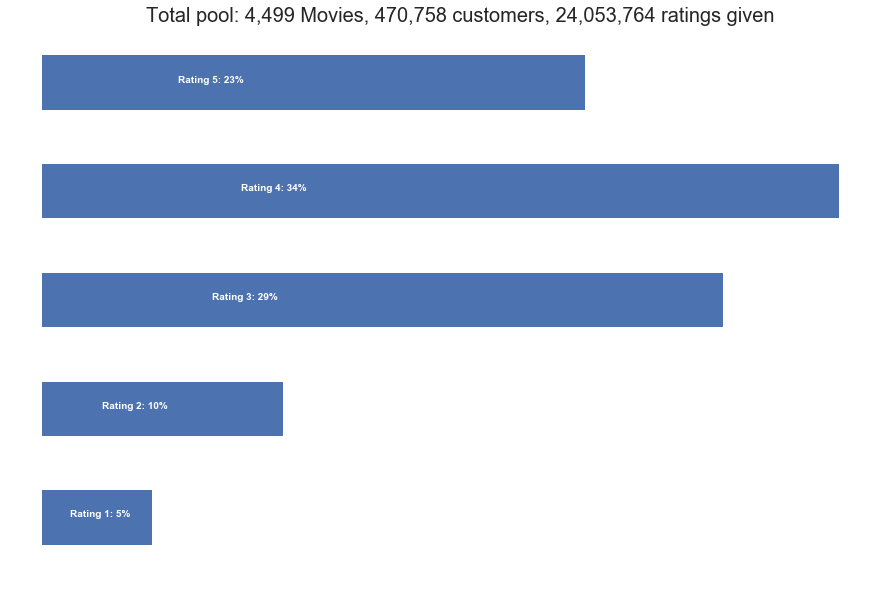

In [18]:
p = df.groupby('Rating')['Rating'].agg(['count'])
ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

## Data Processing

In [20]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()
df_nan.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [22]:
movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [23]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
df.head()

,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


#### Remove movie with too less reviews (they are relatively not popular)
#### Remove customer who give too less reviews (they are relatively less active)

In [24]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 3884.0
Customer minimum times of review: 79.0


In [25]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))

Original Shape: (24053764, 3)
After Trim Shape: (13528427, 3)


In [26]:
df.head()

,Cust_Id,Rating,Movie_Id
5109,785314,1.0,8
5110,243963,3.0,8
5112,1447783,4.0,8
5116,1912665,1.0,8
5119,1744889,1.0,8


In [30]:
n_users = df.Cust_Id.nunique()
n_movies = df.Movie_Id.nunique()
print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_movies))
sparsity=round(1.0-len(df)/float(n_users*n_movies),3)
print('The sparsity level of Netflix Rating is ' +  str(sparsity*100) + '%')

Num. of Users: 95325
Num of Movies: 900
The sparsity level of Netflix Rating is 84.2%


In [27]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
df_p.head()

Movie_Id,8,17,18,26,28,30,33,44,46,52,...,4454,4465,4472,4474,4479,4488,4490,4492,4493,4496
Cust_Id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5.0,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,...,NaN,2.0,3.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_title = pd.read_csv("..\\data\\netflix-prize-data\\movie_titles.csv", encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
df_title.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


## SVD Recommander System

In [33]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

C:\Users\yiqin\Anaconda3\lib\site-packages\surprise\evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
C:\Users\yiqin\Anaconda3\lib\site-packages\surprise\dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9870
MAE:  0.7983
------------
Fold 2
RMSE: 0.9808
MAE:  0.7946
------------
Fold 3
RMSE: 0.9850
MAE:  0.8010
------------
------------
Mean RMSE: 0.9843
Mean MAE : 0.7980
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.7983176172615922,
                             0.7945899728676996,
                             0.8009983789642111],
                            'rmse': [0.9870446641102222,
                             0.9807824357094257,
                             0.9849561483197703]})

In [34]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
df_785314

Movie_Id
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443                             Like Water for Chocolate
2452        Lord of the Rings: The Fellowship of the Ring
2465 

In [35]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.train(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
user_785314.head(10)

C:\Users\yiqin\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


,Year,Name,Estimate_Score
1551,1983.0,Black Adder,5.000000
3045,1990.0,The Simpsons: Treehouse of Horror,4.882298
2171,1991.0,The Simpsons: Season 3,4.866717
2101,1994.0,The Simpsons: Season 6,4.854240
3520,2000.0,Coupling: Season 1,4.763886
2113,2002.0,Firefly,4.739156
4391,1993.0,Army of Darkness,4.721435
2056,2001.0,Buffy the Vampire Slayer: Season 6,4.663141
3443,2004.0,Family Guy: Freakin' Sweet Collection,4.662152
3167,1987.0,Evil Dead 2: Dead by Dawn,4.647649
